## Outcome prediction after Chikungunya hospitalization

#### MC853 - Unicamp

- Leandro Henrique Silva Resende – 213437 

- Pietro Grazzioli Golfeto – 223694 

- Yvens Ian Prado Porto – 184031 

In [1]:
# Required Libraries
# This script focuses on fairness analysis. It assumes that the data
# has already been preprocessed (cleaned, imputed, scaled) and that the
# training data has also been resampled (e.g., using SMOTE and RandomUnderSampler).
# We used Python 3.10.12

import pandas as pd # For data manipulation and analysis
import os           # For operating system dependent functionalities like path handling
import numpy as np  # For numerical operations
import import_ipynb
from plots import plot_fairness_tpr_metrics, plot_fairness_class_metrics

# Define random state for reproducibility
random_state = 42

# Scikit-learn components for modeling and evaluation
from sklearn.ensemble import RandomForestClassifier # Random Forest classification model
from sklearn.metrics import classification_report, balanced_accuracy_score # For model performance evaluation

# Warnings management
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning) # Suppress DataConversionWarning for cleaner output

In [2]:
# Define paths to the PREPROCESSED and PRE-RESAMPLED dataset files.
# These paths point to the CSV files that were generated by the separate training/preprocessing script.
# They ensure that these file paths are correct and the files exist.

# --- Data Usage Strategy ---
# - `_resampled.csv` (X_train_fit_path, y_train_fit_path):
#   These datasets are used exclusively for FITTING/TRAINING the machine learning models.
#   The training features (X) and labels (y) in these files have undergone resampling
#   to address class imbalance.
#
# - `_processed.csv` (X_train_eval_path, y_train_eval_path):
#   These datasets contain the training data AFTER preprocessing (imputation, scaling, etc.)
#   but BEFORE resampling. They represent the original distribution of the training data.
#   They are used for EVALUATING fairness metrics on the training set because fairness should
#   be assessed against the true underlying data distribution.
#
# - `_processed.csv` (X_test_eval_path, y_test_eval_path):
#   These datasets contain the preprocessed test data. The test data is NEVER resampled.
#   It's used for all TEST SET evaluations (performance and fairness) to get an unbiased
#   estimate of how the model would perform on new, unseen data.

leandro_path = {
    'X_train_fit_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/X_train_resampled.csv',
    'y_train_fit_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/y_train_resampled.csv',
    'X_train_eval_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/X_train_processed.csv',
    'y_train_eval_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/y_train_processed.csv',
    'X_test_eval_path':  '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/X_test_processed.csv',
    'y_test_eval_path':  '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/y_test_processed.csv',
}

pietro_path = {
    'X_train_fit_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_train_resampled.csv',
    'y_train_fit_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_train_resampled.csv',
    'X_train_eval_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_train_processed.csv',
    'y_train_eval_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_train_processed.csv',
    'X_test_eval_path':  '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_test_processed.csv',
    'y_test_eval_path':  '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_test_processed.csv',
}

In [3]:
# Set the active path configuration based on file availability.
# This allows the script to be run by different users without manual path changes each time.
path_config_fairness = None # Initialize with None

# Check if all necessary files for a user's path configuration exist.
# It's important to check for both fitting and evaluation files.
if os.path.isfile(pietro_path['X_train_fit_path']) and os.path.isfile(pietro_path['X_train_eval_path']):
    path_config_fairness = pietro_path # Use Pietro's path configuration
    print("Using Pietro's path configuration.")
elif os.path.isfile(leandro_path['X_train_fit_path']) and os.path.isfile(leandro_path['X_train_eval_path']):
    path_config_fairness = leandro_path # Use Leandro's path configuration
    print("Using Leandro's path configuration.")
else:
    # If the required files for either configuration are not found, raise an error.
    raise Exception('Preprocessed/Resampled data paths not found. Please check paths and ensure the preprocessing script has been run and generated all necessary files.')

# Define specific file path variables using the selected configuration.
# `os.path.expanduser` resolves '~' to the user's home directory.

# Paths for Model Fitting (uses resampled training data)
X_train_fit_path = os.path.expanduser(path_config_fairness['X_train_fit_path'])
y_train_fit_path = os.path.expanduser(path_config_fairness['y_train_fit_path'])

# Paths for Training Set Evaluation (uses original preprocessed distribution)
X_train_eval_path = os.path.expanduser(path_config_fairness['X_train_eval_path'])
y_train_eval_path = os.path.expanduser(path_config_fairness['y_train_eval_path'])

# Paths for Test Set Evaluation (uses original preprocessed distribution)
X_test_eval_path = os.path.expanduser(path_config_fairness['X_test_eval_path'])
y_test_eval_path = os.path.expanduser(path_config_fairness['y_test_eval_path'])

Using Pietro's path configuration.


In [4]:
# Load the datasets from the specified CSV file paths.
# `low_memory=False` is a pandas `read_csv` option that can help with type inference for large files with mixed data types.
# `.squeeze("columns")` converts a single-column DataFrame (which `read_csv` might produce for y_train/y_test) into a pandas Series.

# --- Data for Model FITTING ---
# These are the resampled training features and labels. Models will be trained on this data.
print("Loading data for model fitting (resampled training data)...")
X_train_fit = pd.read_csv(X_train_fit_path, low_memory=False)
y_train_fit = pd.read_csv(y_train_fit_path, low_memory=False).squeeze("columns")
print(f"X_train_fit shape: {X_train_fit.shape}, y_train_fit shape: {y_train_fit.shape}")

# --- Data for EVALUATING on Training Set's Original Distribution ---
# These are the preprocessed (but not resampled) training features and labels.
# Used to assess fairness on the original training data characteristics.
print("\nLoading data for training set evaluation (preprocessed, original distribution)...")
X_train_eval = pd.read_csv(X_train_eval_path, low_memory=False)
y_train_eval = pd.read_csv(y_train_eval_path, low_memory=False).squeeze("columns")
print(f"X_train_eval shape: {X_train_eval.shape}, y_train_eval shape: {y_train_eval.shape}")

# --- Data for EVALUATING on Test Set ---
# These are the preprocessed test features and labels.
# Used for final model performance and fairness assessment on unseen data.
print("\nLoading data for test set evaluation (preprocessed)...")
X_test_eval = pd.read_csv(X_test_eval_path, low_memory=False)
y_test_eval = pd.read_csv(y_test_eval_path, low_memory=False).squeeze("columns")
print(f"X_test_eval shape: {X_test_eval.shape}, y_test_eval shape: {y_test_eval.shape}")

Loading data for model fitting (resampled training data)...
X_train_fit shape: (15584, 37), y_train_fit shape: (15584,)

Loading data for training set evaluation (preprocessed, original distribution)...
X_train_eval shape: (20983, 37), y_train_eval shape: (20983,)

Loading data for test set evaluation (preprocessed)...
X_test_eval shape: (10109, 37), y_test_eval shape: (10109,)


In [5]:
# Information Note:
# Preprocessing steps (like imputation, outlier removal, scaling) and the
# resampling pipeline (SMOTE, RandomUnderSampler) are NO LONGER EXECUTED in this script.
# This is because this script now loads data that has ALREADY undergone these transformations
# in a separate, preceding script (the "training code" or "preprocessing code").
# This makes the fairness analysis script cleaner and faster, focusing solely on its main task.
# Imports for these removed steps (e.g., KNNImputer, RobustScaler, SMOTE, etc.) have also been removed.

In [6]:
# Define global constants for the analysis

# Define the sensitive attribute
# 'GENDER' contains binary values representing gender groups (0 for male, 1 for female).
SENSITIVE_ATTR_NAME = 'GENDER' 

# Pre-defined best hyperparameters for the Random Forest model.
# These parameters have been determined through a hyperparameter tuning process (GridSearchCV) in a previous stage.
# Using fixed, optimized parameters ensures consistency in model training for fairness comparison.
BEST_RF_MODEL_PARAMS = {
    'class_weight': {0: 1, 1: 3},           # Assigns different weights to classes, helpful for imbalanced data. Here, class 1 is weighted more.
    'max_depth': 10,                        # Maximum depth of individual trees in the forest. Controls complexity.
    'min_samples_split': 30,                # Minimum number of samples required to split an internal node.
    'n_estimators': 100,                    # Number of trees in the random forest.
    'random_state': random_state,           # Seed for the random number generator, ensuring reproducibility of model training.
    'n_jobs': -1                            # Use all available CPU cores for training, speeding up the process.
}

In [7]:
# --- Helper Functions ---

def _prepare_features(df: pd.DataFrame, sensitive_attr_column_name: str, drop_sensitive_attr: bool = False) -> pd.DataFrame:
    """
    Prepares the feature set from a DataFrame by:
    1. Removing any columns that might have been added from previous model predictions (those starting with 'y_pred_').
    2. Optionally, dropping the column specified by `sensitive_attr_column_name`.

    Parameters:
        df (pd.DataFrame): The input DataFrame from which to select/prepare features.
        sensitive_attr_column_name (str): The name of the sensitive attribute column.
        drop_sensitive_attr (bool, optional): If True, the sensitive attribute column will be removed.
                                             Defaults to False (sensitive attribute is kept).

    Returns:
        pd.DataFrame: A DataFrame containing only the selected base features.
    """
    # Create a list of columns to drop. Start with any columns that are named like predictions from previous runs.
    cols_to_drop = [c for c in df.columns if c.startswith('y_pred_')]
    
    # If the `drop_sensitive_attr` flag is True, add the sensitive attribute column to the list of columns to drop.
    if drop_sensitive_attr:
        cols_to_drop.append(sensitive_attr_column_name)
        
    # Drop the identified columns from the DataFrame. A copy is made implicitly by `drop`.
    # `errors='ignore'` prevents errors if a column in `cols_to_drop` isn't found.
    return df.drop(columns=cols_to_drop, errors='ignore')

def calculate_equal_opportunity(y_true: pd.Series,
                                y_pred_values: np.ndarray,
                                sensitive_attribute_col_values: pd.Series) -> tuple[float, float, float]:
    """
    Calculates the Equal Opportunity metric.
    Compares True Positive Rate (TPR) across groups defined by `sensitive_attribute_col_values`.
    TPR = P(predicted_label = 1 | true_label = 1, group).
    A model satisfies Equal Opportunity if P(ŷ=1 | Y=1, A=a) is the same for all groups 'a'.

    Parameters:
        y_true (pd.Series): Ground truth labels (0 or 1).
        y_pred_values (np.ndarray): Predicted labels (0 or 1) by the model.
        sensitive_attribute_col_values (pd.Series): Values of the sensitive attribute (0 or 1)
                                                    corresponding to y_true and y_pred_values.

    Returns:
        tuple[float, float, float]: 
            tpr_group1 (float): True Positive Rate for the group where sensitive_attribute_value == 1.
            tpr_group0 (float): True Positive Rate for the group where sensitive_attribute_value == 0.
            abs_diff (float): Absolute difference between tpr_group1 and tpr_group0.
                                A smaller difference indicates better fairness in terms of equal opportunity.
                                Returns np.nan for a group's TPR if there are no true positive instances in that group.
    """
    # Mask for instances where the true label is positive (Y=1)
    true_positives_mask = (y_true == 1)

    def _calculate_tpr_for_subgroup(subgroup_identity_mask: pd.Series) -> float:
        """Helper to calculate TPR for a specific subgroup among true positives."""
        # Combine true positive mask with the mask identifying the subgroup
        combined_mask = true_positives_mask & subgroup_identity_mask
        # Calculate TPR if any such instances exist, otherwise return NaN
        # This is effectively sum(predictions_for_group_among_true_positives) / count(group_among_true_positives).
        return (y_pred_values[combined_mask].mean() if combined_mask.any() else np.nan)

    # TPR for the group where sensitive attribute is 1 (female)
    tpr_group1 = _calculate_tpr_for_subgroup(sensitive_attribute_col_values == 1)
    # TPR for the group where sensitive attribute is 0 (male)
    tpr_group0 = _calculate_tpr_for_subgroup(sensitive_attribute_col_values == 0)
    
    # Absolute difference in TPRs
    abs_tpr_difference = abs(tpr_group1 - tpr_group0) if pd.notna(tpr_group1) and pd.notna(tpr_group0) else np.nan
    
    return tpr_group1, tpr_group0, abs_tpr_difference

In [8]:
# --- Main Fairness Analysis Function ---

def run_fairness_analysis_scenario(
    x_fit: pd.DataFrame,
    y_fit: pd.Series,
    x_eval_train: pd.DataFrame,
    y_eval_train: pd.Series,
    x_eval_test: pd.DataFrame,
    y_eval_test: pd.Series,
    sens_attr_name: str,
    model_hyperparams: dict,
    include_sens_attr_in_training: bool,
    description_suffix: str
) -> tuple[RandomForestClassifier, dict]:
    """
    Runs a complete fairness analysis scenario for a model.
    This includes:
    1. Preparing features for training (optionally including/excluding the sensitive attribute).
    2. Training a RandomForestClassifier.
    3. Making predictions on evaluation datasets (training and test sets, using original distributions).
    4. Calculating and printing Equal Opportunity fairness metrics.

    Parameters:
        x_fit (pd.DataFrame): Resampled training features for model fitting.
        y_fit (pd.Series): Resampled training labels for model fitting.
        x_eval_train (pd.DataFrame): Preprocessed training features (original distribution) for evaluation.
        y_eval_train (pd.Series): Preprocessed training labels (original distribution) for evaluation.
        x_eval_test (pd.DataFrame): Preprocessed test features for evaluation.
        y_eval_test (pd.Series): Preprocessed test labels for evaluation.
        sens_attr_name (str): The name of the sensitive attribute column.
        model_hyperparams (dict): Hyperparameters for the RandomForestClassifier.
        include_sens_attr_in_training (bool): If True, the sensitive attribute is included in training features.
                                              If False, it's excluded.
        description_suffix (str): A string to append to print statements (e.g., "WITH Gender Column").

    Returns:
        tuple:
            trained_rf_model (RandomForestClassifier): The trained model instance.
            fairness_metrics_results (dict): A dictionary containing fairness metrics for train and test sets.
                                             Example: {'train': (p1, p2, diff), 'test': (p1, p2, diff)}
    """
    print(f"\n--- Running Fairness Scenario: Model {description_suffix} ---")

    # 1. Prepare features for fitting the model.
    #    `drop_sensitive_attr` is the inverse of `include_sens_attr_in_training`.
    #    A copy of x_fit is used to avoid modifying the original DataFrame.
    print(f"Preparing features for fitting model {description_suffix} (from resampled data)...")
    features_for_fitting = _prepare_features(
        df=x_fit.copy(),
        sensitive_attr_column_name=sens_attr_name,
        drop_sensitive_attr=(not include_sens_attr_in_training) # If including, don't drop. If not including, do drop.
    )
    
    # 2. Initialize and train the Random Forest classifier.
    trained_rf_model = RandomForestClassifier(**model_hyperparams)
    print(f"Training Random Forest model {description_suffix} (on resampled data)...")
    trained_rf_model.fit(features_for_fitting, y_fit)

    # 3. Make predictions on the EVALUATION datasets (original preprocessed distributions).
    #    Features for prediction must be prepared consistently with how the model was trained.
    
    # Predictions for training set fairness evaluation:
    # Use x_eval_train (original distribution).
    features_for_train_eval_pred = _prepare_features(
        df=x_eval_train.copy(),
        sensitive_attr_column_name=sens_attr_name,
        drop_sensitive_attr=(not include_sens_attr_in_training)
    )
    y_pred_train_eval_values = trained_rf_model.predict(features_for_train_eval_pred)

    # Predictions for test set performance and fairness evaluation:
    # Use x_eval_test (original distribution).
    features_for_test_eval_pred = _prepare_features(
        df=x_eval_test.copy(),
        sensitive_attr_column_name=sens_attr_name,
        drop_sensitive_attr=(not include_sens_attr_in_training)
    )
    y_pred_test_eval_values = trained_rf_model.predict(features_for_test_eval_pred)

    # 4. Calculate Equal Opportunity metrics.
    #    On the training set (using original distribution data for evaluation).
    eo_p1_train, eo_p0_train, eo_diff_train = calculate_equal_opportunity(
        y_true=y_eval_train,
        y_pred_values=y_pred_train_eval_values,
        sensitive_attribute_col_values=x_eval_train[sens_attr_name]
    )
    #    On the test set.
    eo_p1_test, eo_p0_test, eo_diff_test = calculate_equal_opportunity(
        y_true=y_eval_test,
        y_pred_values=y_pred_test_eval_values,
        sensitive_attribute_col_values=x_eval_test[sens_attr_name]
    )

    # Store fairness metrics
    fairness_metrics_results = {
        'train': {'tpr_group1': eo_p1_train, 'tpr_group0': eo_p0_train, 'diff': eo_diff_train},
        'test':  {'tpr_group1': eo_p1_test,  'tpr_group0': eo_p0_test,  'diff': eo_diff_test}
    }
    
    # Print the fairness results. Assuming group 1 is female, group 0 is male based on SENSITIVE_ATTR_NAME context.
    print(f"\n=== Fairness Metrics: Model {description_suffix} ===")
    print(f"Equal Opportunity - Training Set (Original Dist.): Female TPR={eo_p1_train:.3f}, Male TPR={eo_p0_train:.3f}, Difference={eo_diff_train:.3f}")
    print(f"Equal Opportunity - Test Set                     : Female TPR={eo_p1_test:.3f}, Male TPR={eo_p0_test:.3f}, Difference={eo_diff_test:.3f}")
    
    return trained_rf_model, fairness_metrics_results

In [9]:
def show_performance_report(
    estimator: RandomForestClassifier, 
    x_data_for_eval: pd.DataFrame, 
    y_data_for_eval: pd.Series,    
    model_description_text: str, 
    drop_sens_attr_for_predict: bool = False
):
    """
    Prints a classification report and key accuracy scores in a formatted, aligned table.
    """
    # Prepare features for prediction, ensuring consistency with how the model was trained.
    features_for_prediction = _prepare_features(
        df=x_data_for_eval.copy(), 
        sensitive_attr_column_name=SENSITIVE_ATTR_NAME, # Uses global SENSITIVE_ATTR_NAME
        drop_sensitive_attr=drop_sens_attr_for_predict
    )
    y_model_predictions = estimator.predict(features_for_prediction)
    
    report_dict = classification_report(
        y_data_for_eval, 
        y_model_predictions, 
        zero_division=0, 
        digits=4,
        output_dict=True  # Output as a dictionary for easy manipulation
    )
    
    overall_accuracy = report_dict.get('accuracy', 0.0) # Get overall accuracy
    bal_acc = balanced_accuracy_score(y_data_for_eval, y_model_predictions)
    
    # Remove the overall accuracy from the report dict to keep the table clean
    if 'accuracy' in report_dict:
        del report_dict['accuracy']
        
    report_df = pd.DataFrame(report_dict).transpose()    
    report_df.rename(columns={'support': 'Count'}, inplace=True)
    report_df['Count'] = report_df['Count'].astype(int)
    report_df.index.name = 'Class'
    
    table_str = report_df.to_string()
    lines = table_str.split('\n')
    
    # Find where the 'macro avg' line starts to insert our separator
    separator_pos = -1
    for i, line in enumerate(lines):
        if line.strip().startswith('macro avg'):
            separator_pos = i
            break
            
    # Insert the separator line if the position was found
    if separator_pos != -1:
        separator_line = '-' * len(lines[0])
        lines.insert(separator_pos, separator_line)
        
    final_table_str = '\n'.join(lines)
    
    print("\n" + "="*70)
    print(f"--- Performance Report: {model_description_text} ---")
    print("="*70)
    print(final_table_str)
    
    print("-" * 70)
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print("=" * 70)

    return report_df


In [10]:
# --- Execute Fairness Analysis Scenarios ---

# Scenario 1: Model trained WITH the sensitive attribute ('GENDER')
rf_model_with_gender, fairness_results_with_gender = run_fairness_analysis_scenario(
    x_fit=X_train_fit,
    y_fit=y_train_fit,
    x_eval_train=X_train_eval,
    y_eval_train=y_train_eval,
    x_eval_test=X_test_eval,
    y_eval_test=y_test_eval,
    sens_attr_name=SENSITIVE_ATTR_NAME,
    model_hyperparams=BEST_RF_MODEL_PARAMS,
    include_sens_attr_in_training=True, # Key flag for this scenario
    description_suffix="WITH GENDER Column"
)

# Scenario 2: Model trained WITHOUT the sensitive attribute ('GENDER')
rf_model_without_gender, fairness_results_without_gender = run_fairness_analysis_scenario(
    x_fit=X_train_fit,
    y_fit=y_train_fit,
    x_eval_train=X_train_eval,
    y_eval_train=y_train_eval,
    x_eval_test=X_test_eval,
    y_eval_test=y_test_eval,
    sens_attr_name=SENSITIVE_ATTR_NAME,
    model_hyperparams=BEST_RF_MODEL_PARAMS,
    include_sens_attr_in_training=False, # Key flag for this scenario
    description_suffix="WITHOUT GENDER Column"
)


--- Running Fairness Scenario: Model WITH GENDER Column ---
Preparing features for fitting model WITH GENDER Column (from resampled data)...
Training Random Forest model WITH GENDER Column (on resampled data)...

=== Fairness Metrics: Model WITH GENDER Column ===
Equal Opportunity - Training Set (Original Dist.): Female TPR=0.871, Male TPR=0.939, Difference=0.067
Equal Opportunity - Test Set                     : Female TPR=0.759, Male TPR=0.870, Difference=0.112

--- Running Fairness Scenario: Model WITHOUT GENDER Column ---
Preparing features for fitting model WITHOUT GENDER Column (from resampled data)...
Training Random Forest model WITHOUT GENDER Column (on resampled data)...

=== Fairness Metrics: Model WITHOUT GENDER Column ===
Equal Opportunity - Training Set (Original Dist.): Female TPR=0.889, Male TPR=0.925, Difference=0.036
Equal Opportunity - Test Set                     : Female TPR=0.808, Male TPR=0.816, Difference=0.008


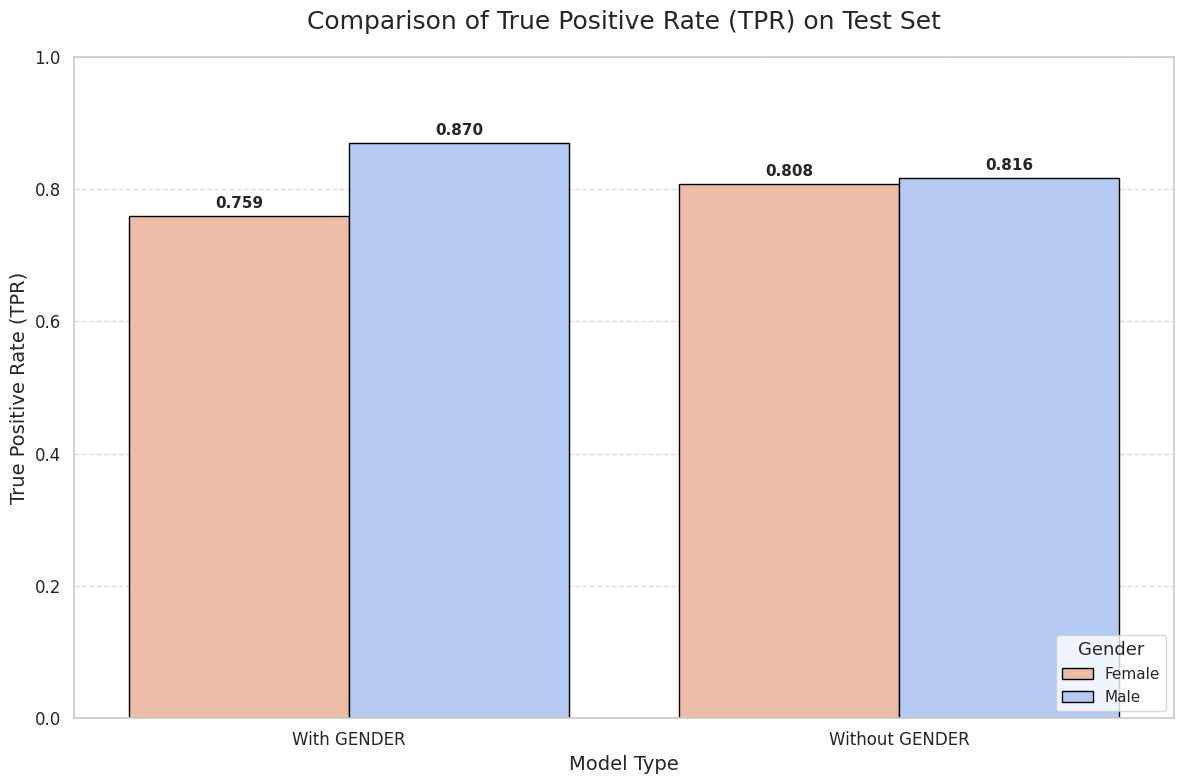

In [11]:
# Plot the metrics from the test set
plot_fairness_tpr_metrics(
    results_with_attr=fairness_results_with_gender,
    results_without_attr=fairness_results_without_gender
)

In [12]:
# Performance for the model trained WITH Gender on the test set
report_with_gender_df = show_performance_report(
    estimator=rf_model_with_gender, 
    x_data_for_eval=X_test_eval, 
    y_data_for_eval=y_test_eval, 
    model_description_text="Random Forest WITH GENDER – Test Set", 
    drop_sens_attr_for_predict=False # Model was trained with gender, so don't drop for prediction
)


--- Performance Report: Random Forest WITH GENDER – Test Set ---
              precision    recall  f1-score  Count
Class                                             
0              0.970026  0.478107  0.640516   9341
1              0.114441  0.820312  0.200861    768
--------------------------------------------------
macro avg      0.542234  0.649210  0.420689  10109
weighted avg   0.905026  0.504105  0.607115  10109
----------------------------------------------------------------------
Accuracy: 0.5041
Balanced Accuracy: 0.6492


In [13]:
# Performance for the model trained WITHOUT Gender on the test set
report_without_gender_df = show_performance_report(
    estimator=rf_model_without_gender,  
    x_data_for_eval=X_test_eval, 
    y_data_for_eval=y_test_eval, 
    model_description_text="Random Forest WITHOUT GENDER – Test Set", 
    drop_sens_attr_for_predict=True # Model was trained without gender, so drop for prediction
)


--- Performance Report: Random Forest WITHOUT GENDER – Test Set ---
              precision    recall  f1-score  Count
Class                                             
0              0.967589  0.460229  0.623767   9341
1              0.110131  0.812500  0.193970    768
--------------------------------------------------
macro avg      0.538860  0.636365  0.408868  10109
weighted avg   0.902447  0.486992  0.591114  10109
----------------------------------------------------------------------
Accuracy: 0.4870
Balanced Accuracy: 0.6364


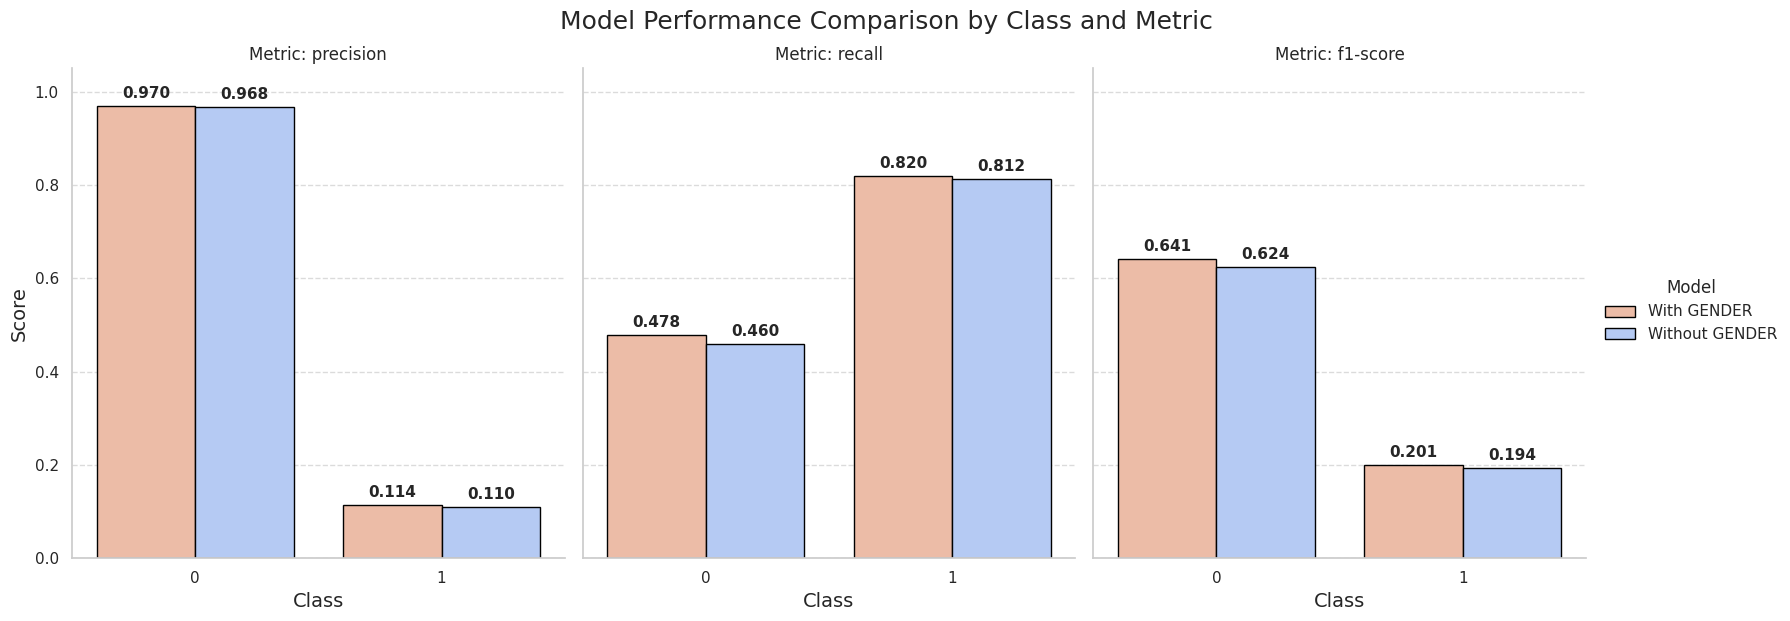

In [14]:
plot_fairness_class_metrics(
    report_with_gender=report_with_gender_df,
    report_without_gender=report_without_gender_df
)